# Objetivo

Queremos criar um modelo preditivo para o produto de Financiamento de veículos.
A variável target é "TARGET_M3OVER30", que é a marcação de clientes que estavam com 30 dias ou mais de atraso após 3 meses da contratação (conceito de Over).

# Análise dos dados

A base de dados possui 7000 casos, com taxa de maus de 28% e referentes aos meses de 10/21 a 12/21.
Tal taxa de maus é estável ao longo desses 3 meses.

A base de dados precisou de alguns pequenos ajustes, os quais foram demarcados no código. As variáveis "idade" e "score_mercado" foram removidas do processo de modelagem, a idade por apresentar inconsistências que deveriam ser averiguadas, e a variável score_mercado para contenção de custos e porque não apresenta boa correlação com a variável target.

Há clientes com múltiplos empréstimos num curto espaço de tempo, às vezes no mesmo mês. É de se questionar se não deveria existir um período de carência.

# Modelagem

A base de dados foi divida da seguinte forma: <br>
Base de treino: Meses 10/21 e 11/21 <br>
Base de teste: Mês 12/21

Testamos os algoritmos Árvore de Decisão, LightGBM e XGBoost. <br>
Os 3 algoritmos trazem resultados de KS / AUCROC muito parecidos tanto na base de treino quanto na base de teste, e por conta disso seguimos com o modelo de Árvore de Decisão por seu alto grau de explicabilidade.

Os piores nós da Árvore de Decisão são de clientes ou com baixa renda ou nula ("renda <= 1535.83 & limite_cartao <= 3357.18" e "renda <= 1535.83 & limite_cartao > 3357.18") ou de clientes com limite do cartão zerado ou nulo ("renda > 5431.54 & limite_cartao <= 29.67" e "renda > 1535.83 & renda <= 5431.54 & limite_cartao <= 29.67"), e portanto é de se provocar se os critérios acima não deveriam estar, de alguma forma, incoporados na política dado o resultado de inadimplência.

Como estamos falando de um corte da renda muito próximo ao salário mínimo, no frigir dos ovos podemos estar lidando com clientes autônomos, e que talvez haja formas de contornar a situação do "negue qualquer pessoa com renda abaixo de X" com mais informações disponíveis.

É importante notar como alguns nós da árvore obtida têm mudanças bruscas de inadimplência na base de teste (nós 3, 6 e 19), e que isso pode significar um alto grau de instabilidade do público. Como o modelo em si já está com uma performance no limite do aceitável, podemos seguir desta forma num primeiro momento, monitorando o desempenho do modelo, e em paralelo buscarmos novas fontes de dados que sejam menos voláteis.

Por mais que o score de mercado tenha apresentado uma correlação muito baixa com o target, testamos criar um score cruzado com o score de mercado. Não trouxe resultados interessantes, de forma que tal abordagem foi descartada.

In [1]:
import pandas as pd
import numpy as np
import re
from datetime import datetime
from ydata_profiling import ProfileReport

from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import roc_curve, roc_auc_score

from sklearn.tree import DecisionTreeClassifier, plot_tree
import lightgbm as lgbm
import xgboost as xgb

from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt

pd.set_option('display.max_colwidth', None)


In [2]:
df = pd.read_csv('./data/case_classificacao_veiculos.txt', sep=';')
df.head()

,CLIENTE,DATA_FINANCIAMENTO,TARGET_M3OVER30,IDADE,ESTADO,RENDA,LIMITE_CARTAO,VALOR_FINANC_VEICULOS_ATUAL,SCORE_MERCADO,VALOR_VEICULO,ANO_VEICULO
0,0,2021-10,1,25.0,SP,4760.043944,21361.878421,0.000000,882.238536,"27802,51",2020.0
1,1,2021-11,1,27.0,CE,1700.000000,6551.924996,0.000000,956.692365,"34525,51",2020.0
2,2,2021-10,1,32.0,RJ,4004.147555,12831.296653,29246.823466,610.724337,"36178,14",2020.0
3,3,2021-12,1,39.0,CE,12250.000000,11252.113450,111621.080000,815.069341,"38681,99",2020.0
4,4,2021-12,0,38.0,RJ,1800.000000,11087.609068,0.000000,947.383539,"30742,18",2021.0


# Análise das variáveis preditivas e limpeza de dados

In [3]:
# Anotações:

# [OK, mas era interessante entender com Negócios] Um mesmo cliente pode ter mais que um empréstimo
# [OK] Os financiamentos são de 10/21 a 12/21
# [OK] A target é 0 ou 1, sem nulos
# [OK] A idade vai de 19 a 77 anos, com nulos
# [OK] Tem 6 estados, sem nulos. SP é o mais populoso
# [OK, outliers] A renda vai de 800 a 106k, ou seja, tem outliers. Sem nulos
# [OK, outliers] O limite do cartão tem zeros, nulos e outliers. Tem que ajustar essa variável com cuidado
# [OK, mas eu precisava entender melhor essa variável] O valor financiado tem bastante zeros e alguns nulos
# [OK] O score de mercado possui alguns poucos casos nulos
# [OK] O valor do veículo está como categórico porque está com separador de casa decimal vírgula invés de ponto, precisa ajustar.
# [OK] O ano do veículo possui poucos casos nulos

In [4]:
profile = ProfileReport(df, minimal=True)
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [5]:
df.columns = df.columns.str.lower()

df['valor_veiculo'] = df['valor_veiculo'].str.replace(',','.').astype(float)

In [6]:
# Anotações sobre o valor dos veículos:

# A variável aparenta estar... normal rsrs
# Possui poucos nulos, precisa ajustar
# Possui outliers, tomar cuidado com isso

In [7]:
ProfileReport(df[['valor_veiculo']], minimal=True)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [8]:
# Todos foram colocados como -1 pra que criemos uma categoria separada. 
# Por exemplo, tem clientes com limite do cartão zero, e deve haver diferença entre essa situação e o nulo sob a ótica de Negócios

df['idade'] = df['idade'].fillna(-1)
df['limite_cartao'] = df['limite_cartao'].fillna(-1)
df['valor_financ_veiculos_atual'] = df['valor_financ_veiculos_atual'].fillna(-1)
df['score_mercado'] = df['score_mercado'].fillna(-1)
df['valor_veiculo'] = df['valor_veiculo'].fillna(-1)
df['ano_veiculo'] = df['ano_veiculo'].fillna(-1)

In [9]:
# Anotações da análise de duplicados:

# A variável idade não parece adequada, pois o mesmo cliente possui diversas entradas para idade em datas de financiamento com apenas um mês de diferença
# Todas as outras variáveis parecem fazer sentido. O valor do veículo e score de mercado mudam, mas isso pode acontecer
# Fica a pergunta se um mesmo cliente deveria poder fazer múltiplos empréstimos num intervalo tão curto, 
# tal como no mesmo mês. Não deveria ter algum tipo de carência?

# Sugestão: criar uma variável que seja "tempo desde último empréstimo". Como no meu caso só sei que aconteceu no mesmo mês, 
# não tenho como dizer qual empréstimo ocorreu primeiro e portanto não criarei a variável.

In [10]:
df.loc[df['cliente'].duplicated(False)].sort_values(['cliente', 'data_financiamento'])

,cliente,data_financiamento,target_m3over30,idade,estado,renda,limite_cartao,valor_financ_veiculos_atual,score_mercado,valor_veiculo,ano_veiculo
3489,3,2021-10,1,42.0,CE,12250.000000,11252.113450,118614.738643,769.284761,45537.97,2020.0
3,3,2021-12,1,39.0,CE,12250.000000,11252.113450,111621.080000,815.069341,38681.99,2020.0
2838,3,2021-12,1,40.0,CE,12250.000000,11252.113450,123895.953362,590.841985,35304.28,2020.0
23,23,2021-12,1,31.0,SP,7302.746395,1370.581210,0.000000,841.738437,27091.63,2020.0
345,23,2021-12,1,33.0,SP,7302.746395,1370.581210,0.000000,841.738437,34688.18,2020.0
...,...,...,...,...,...,...,...,...,...,...,...
4369,6979,2021-12,1,37.0,CE,1100.000000,0.000000,0.000000,835.960315,41851.31,2020.0
6889,6985,2021-10,1,29.0,RJ,2050.000000,8158.994182,0.000000,641.000000,42742.89,2020.0
6985,6985,2021-11,1,27.0,RJ,2050.000000,8158.994182,0.000000,924.096727,34992.79,2020.0
2453,6999,2021-12,1,30.0,PR,1100.000000,15440.006121,0.000000,884.000000,44550.91,2021.0


In [11]:
# Transformando a variável de estado em numérica usando apenas os dados da base de treino
inadimplencia_por_estado = df.loc[(df['data_financiamento'] == "2021-10") | (df['data_financiamento'] == "2021-11")].groupby('estado')['target_m3over30'].mean()
df['estado_num'] = df['estado'].map(inadimplencia_por_estado)

# Criando a variável de idade do veículo para que o modelo não enlouqueça conforme o tempo passa. É de se preocupar com a virada do ano.
df['idade_veiculo'] = datetime.now().year - df['ano_veiculo']
df.loc[df['ano_veiculo'] == -1, 'idade_veiculo'] = -1

In [12]:
# Truncando as variáveis para valores com duas casas decimais, de forma a evitarmos possíveis futuros problemas de implementação
df[['renda', 'limite_cartao', 'valor_financ_veiculos_atual', 'score_mercado']] = df[['renda', 'limite_cartao', 'valor_financ_veiculos_atual', 'score_mercado']].round(2)
df.head()

,cliente,data_financiamento,target_m3over30,idade,estado,renda,limite_cartao,valor_financ_veiculos_atual,score_mercado,valor_veiculo,ano_veiculo,estado_num,idade_veiculo
0,0,2021-10,1,25.0,SP,4760.04,21361.88,0.00,882.24,27802.51,2020.0,0.271343,4.0
1,1,2021-11,1,27.0,CE,1700.00,6551.92,0.00,956.69,34525.51,2020.0,0.336576,4.0
2,2,2021-10,1,32.0,RJ,4004.15,12831.30,29246.82,610.72,36178.14,2020.0,0.343023,4.0
3,3,2021-12,1,39.0,CE,12250.00,11252.11,111621.08,815.07,38681.99,2020.0,0.336576,4.0
4,4,2021-12,0,38.0,RJ,1800.00,11087.61,0.00,947.38,30742.18,2021.0,0.343023,3.0


# Análise da variável resposta

In [13]:
# Anotações da variável resposta:

# É estável ao longo das safras
# Parece que as variáveis estado e score de mercado são as com maior correlação
# A variável idade é uma das com menor correlação, o que é ótimo dado que planejo não usá-la, dada a inconsistência levantada anteriormente
# Estranho o limite do cartão ser a variável com menor correlação. Seria um ponto pra entender melhor
# Na base de teste temos alterações, tal como o maior impacto do limite do cartão. Esperemos que não haja um desvio muito alto.

In [14]:
df.groupby('data_financiamento')['target_m3over30'].mean()

data_financiamento
2021-10    0.288889
2021-11    0.282230
2021-12    0.285956
Name: target_m3over30, dtype: float64

In [15]:
df_train = df.loc[(df['data_financiamento'] == "2021-10") | (df['data_financiamento'] == "2021-11")].copy()
df_test = df.loc[(df['data_financiamento'] == "2021-12")].copy()

In [16]:
correlation_matrix = df_train.drop(columns=['cliente', 'data_financiamento', 'estado']).corr()
correlation_matrix['target_m3over30'].abs().sort_values(ascending=False)

target_m3over30                1.000000
estado_num                     0.074439
score_mercado                  0.052703
valor_financ_veiculos_atual    0.037864
idade_veiculo                  0.031827
ano_veiculo                    0.020656
renda                          0.019932
idade                          0.015221
valor_veiculo                  0.014945
limite_cartao                  0.013359
Name: target_m3over30, dtype: float64

In [17]:
correlation_matrix = df_test.drop(columns=['cliente', 'data_financiamento', 'estado']).corr()
correlation_matrix['target_m3over30'].abs().sort_values(ascending=False)

target_m3over30                1.000000
score_mercado                  0.066032
estado_num                     0.054943
valor_financ_veiculos_atual    0.046076
renda                          0.043167
ano_veiculo                    0.040487
idade_veiculo                  0.040487
limite_cartao                  0.036835
idade                          0.012915
valor_veiculo                  0.011182
Name: target_m3over30, dtype: float64

# Modelagem

### Teste com a variável idade, pra eu entender o quanto eu perco de performance se tirá-la

In [18]:
# Anotações sobre o teste com variável idade e score de mercado:

# A base de teste parece razoavelmente diferente da de treino
# O KS do modelo está no limite do aceitável para um modelo de Concessão, que seria um KS de 20
# O score de mercado sozinho não traz um bom resultado, o que não era esperado.

In [19]:
# Calcule o KS
def ks_metric(y_true, y_pred_proba):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
    ks = max(tpr - fpr)
    return ks

In [20]:
X_train = df_train.drop(columns=['target_m3over30', 'cliente', 'data_financiamento', 'estado', 'ano_veiculo'])
y_train = df_train['target_m3over30']

X_test = df_test.drop(columns=['target_m3over30', 'cliente', 'data_financiamento', 'estado', 'ano_veiculo'])
y_test = df_test['target_m3over30']

In [21]:
tree = DecisionTreeClassifier(
    criterion='gini', 
    min_samples_leaf=int(0.05 * len(X_train)),  # Garantir que cada nó tenha pelo menos 5% dos casos
    max_depth=None,
    random_state=42)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
roc_auc_scores = cross_val_score(tree, X_train, y_train, cv=cv, scoring='roc_auc')

tree.fit(X_train, y_train)

y_train_pred_proba = tree.predict_proba(X_train)[:, 1]
y_test_pred_proba = tree.predict_proba(X_test)[:, 1]

# Performance do modelo com idade e score de mercado
auc_roc_train = roc_auc_score(y_train, y_train_pred_proba)
auc_roc_test = roc_auc_score(y_test, y_test_pred_proba)

ks_train = ks_metric(y_train, y_train_pred_proba)
ks_test = ks_metric(y_test, y_test_pred_proba)

print(f'ROC AUC (Cross Validation): {roc_auc_scores.mean():.4f}')
print(f'AUC-ROC Train: {auc_roc_train:.4f}')
print(f'AUC-ROC Test: {auc_roc_test:.4f}')
print('')
print(f'KS Train: {ks_train:.4f}')
print(f'KS Test: {ks_test:.4f}')

ROC AUC (Cross Validation): 0.6036
AUC-ROC Train: 0.6485
AUC-ROC Test: 0.6127

KS Train: 0.2117
KS Test: 0.1892


In [22]:
# Performance com o score de mercado puro
auc_roc_train = roc_auc_score(y_train, df_train['score_mercado'].to_list())
auc_roc_test = roc_auc_score(y_test, df_test['score_mercado'].to_list())

ks_train = ks_metric(y_train, df_train['score_mercado'].to_list())
ks_test = ks_metric(y_test, df_test['score_mercado'].to_list())

print(f'AUC-ROC Train: {auc_roc_train:.4f}')
print(f'AUC-ROC Test: {auc_roc_test:.4f}')
print('')
print(f'KS Train: {ks_train:.4f}')
print(f'KS Test: {ks_test:.4f}')

AUC-ROC Train: 0.4700
AUC-ROC Test: 0.4624

KS Train: 0.0233
KS Test: 0.0035


### Teste sem variáveis de idade e score de mercado

In [23]:
# Anotações do modelo sem idade e score de mercado:

# A performance piorou no treino, mas não no teste. 
# Como a variável idade possui inconsistência e o score de mercado tem custo, seguirei com essa versão.

In [24]:
X_train = df_train.drop(columns=['target_m3over30', 'cliente', 'data_financiamento', 'estado', 'ano_veiculo', 'idade', 'score_mercado'])
y_train = df_train['target_m3over30']

X_test = df_test.drop(columns=['target_m3over30', 'cliente', 'data_financiamento', 'estado', 'ano_veiculo', 'idade', 'score_mercado'])
y_test = df_test['target_m3over30']

In [25]:
tree = DecisionTreeClassifier(
    criterion='gini', 
    min_samples_leaf=int(0.05 * len(X_train)),  # Garantir que cada nó tenha pelo menos 5% dos casos
    max_depth=None,
    random_state=42)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
roc_auc_scores = cross_val_score(tree, X_train, y_train, cv=cv, scoring='roc_auc')
tree.fit(X_train, y_train)

y_train_pred_proba = tree.predict_proba(X_train)[:, 1]
y_test_pred_proba = tree.predict_proba(X_test)[:, 1]

# Performance do modelo sem idade e score de mercado
auc_roc_train = roc_auc_score(y_train, y_train_pred_proba)
auc_roc_test = roc_auc_score(y_test, y_test_pred_proba)

ks_train = ks_metric(y_train, y_train_pred_proba)
ks_test = ks_metric(y_test, y_test_pred_proba)

print(f'ROC AUC (Cross Validation): {roc_auc_scores.mean():.4f}')
print(f'AUC-ROC Train: {auc_roc_train:.4f}')
print(f'AUC-ROC Test: {auc_roc_test:.4f}')
print('')
print(f'KS Train: {ks_train:.4f}')
print(f'KS Test: {ks_test:.4f}')

ROC AUC (Cross Validation): 0.5972
AUC-ROC Train: 0.6370
AUC-ROC Test: 0.5999

KS Train: 0.1968
KS Test: 0.1921


### Otimização de hiperparâmetros dos algortimos Decision Tree, LightGBM e XGBoost

In [26]:
# Decision Tree
dt_param_grid = {
    'min_samples_leaf': [int(0.005 * len(df_train)), int(0.02 * len(df_train)), int(0.05 * len(df_train))],
    'criterion':['gini']
}

# LightGBM
lgb_param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 500],
    'min_data_in_leaf': [int(0.02 * len(df_train)), int(0.05 * len(df_train))],
    'feature_fraction': [0.8, 1.0],
    'bagging_fraction': [0.8, 1.0]
}

# XGBoost
xgb_param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 500],
    'min_child_weight': [int(0.02 * len(df_train)), int(0.05 * len(df_train))],
    'gamma': [0, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'eval_metric': ['auc']
}

search_results = {}

for name, model, param_grid in zip(
    ['Decision Tree', 'LightGBM', 'XGBoost'],
    [DecisionTreeClassifier(random_state=42), lgbm.LGBMClassifier(random_state=42), xgb.XGBClassifier(random_state=42, use_label_encoder=False)],
    [dt_param_grid, lgb_param_grid, xgb_param_grid]
):
    grid_search = GridSearchCV(
        model,
        param_grid=param_grid,
        scoring='roc_auc',
        n_jobs=-1,
        cv=5,
        verbose=1
    )

    grid_search.fit(X_train, y_train)
    
    search_results[name] = {
        'Best Params': grid_search.best_params_,
        'Best Score (AUC)': grid_search.best_score_
    }

search_results_df = pd.DataFrame(search_results)
search_results_df

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 72 candidates, totalling 360 fits
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=231, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=231
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
Fitting 5 folds for each of 216 candidates, totalling 1080 fits


c:\Users\rafae\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:158: UserWarning: [19:15:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


,Decision Tree,LightGBM,XGBoost
Best Params,"{'criterion': 'gini', 'min_samples_leaf': 231}","{'bagging_fraction': 0.8, 'feature_fraction': 0.8, 'learning_rate': 0.01, 'min_data_in_leaf': 231, 'n_estimators': 200}","{'colsample_bytree': 1.0, 'eval_metric': 'auc', 'gamma': 0, 'learning_rate': 0.05, 'min_child_weight': 92, 'n_estimators': 100, 'subsample': 0.8}"
Best Score (AUC),0.597341,0.610858,0.61444


In [27]:
best_params_dt = search_results_df['Decision Tree']['Best Params']
best_params_lgbm = search_results_df['LightGBM']['Best Params']
best_params_xgb = search_results_df['XGBoost']['Best Params']

best_params_dt.update(
    {'random_state':42}
)

best_params_lgbm.update(
    {'random_state':42}
)

best_params_xgb.update(
    {'random_state':42}
)

### Modelagem com hiperparâmetros ajustados

In [28]:
# Anotações sobre modelagem com hiperparâmetros ajustados:

# A árvore de decisão teve resultado pouco pior que as outras técnicas, portanto vou dar continuidade ao projeto com ela dado o ganho de explicabilidade

In [29]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

models = {
    'Decision Tree': DecisionTreeClassifier(**best_params_dt),
    'LightGBM': lgbm.LGBMClassifier(**best_params_lgbm),
    'XGBoost': xgb.XGBClassifier(**best_params_xgb)
}

results = {}
for name, model in models.items():
    auc_scores = []
    ks_scores = []
    for train_index, val_index in skf.split(X_train, y_train):
        X_tr, X_val = X_train.iloc[train_index], X_train.iloc[val_index]
        y_tr, y_val = y_train.iloc[train_index], y_train.iloc[val_index]
        
        model.fit(X_tr, y_tr)
        y_val_pred = model.predict_proba(X_val)[:, 1]
        
        # AUC
        auc = roc_auc_score(y_val, y_val_pred)
        auc_scores.append(auc)
        
        # KS
        ks = ks_metric(y_val, y_val_pred)
        ks_scores.append(ks)
    

    # Avaliar no conjunto de treino
    model.fit(X_train, y_train)
    y_train_pred = model.predict_proba(X_train)[:, 1]
    
    train_auc = roc_auc_score(y_train, y_train_pred)
    train_ks = ks_metric(y_train, y_train_pred)
    
    # Avaliar no conjunto de teste
    y_test_pred = model.predict_proba(X_test)[:, 1]
    
    test_auc = roc_auc_score(y_test, y_test_pred)
    test_ks = ks_metric(y_test, y_test_pred)
    
    results[name] = {
        'AUC CV': np.mean(auc_scores),
        'AUC Treino': train_auc,
        'AUC Teste': test_auc,
        'KS CV': np.mean(ks_scores),
        'KS Treino': train_ks,
        'KS Teste': test_ks
    }

final_results_df = pd.DataFrame(results)
final_results_df

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=231, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=231
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=231, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=231
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=231, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=231
[LightGBM] [Warning] b

,Decision Tree,LightGBM,XGBoost
AUC CV,0.597163,0.607722,0.612110
AUC Treino,0.637049,0.687945,0.656718
AUC Teste,0.599898,0.611661,0.613365
KS CV,0.182560,0.195660,0.197587
KS Treino,0.196845,0.279396,0.220121
KS Teste,0.192055,0.192658,0.199750


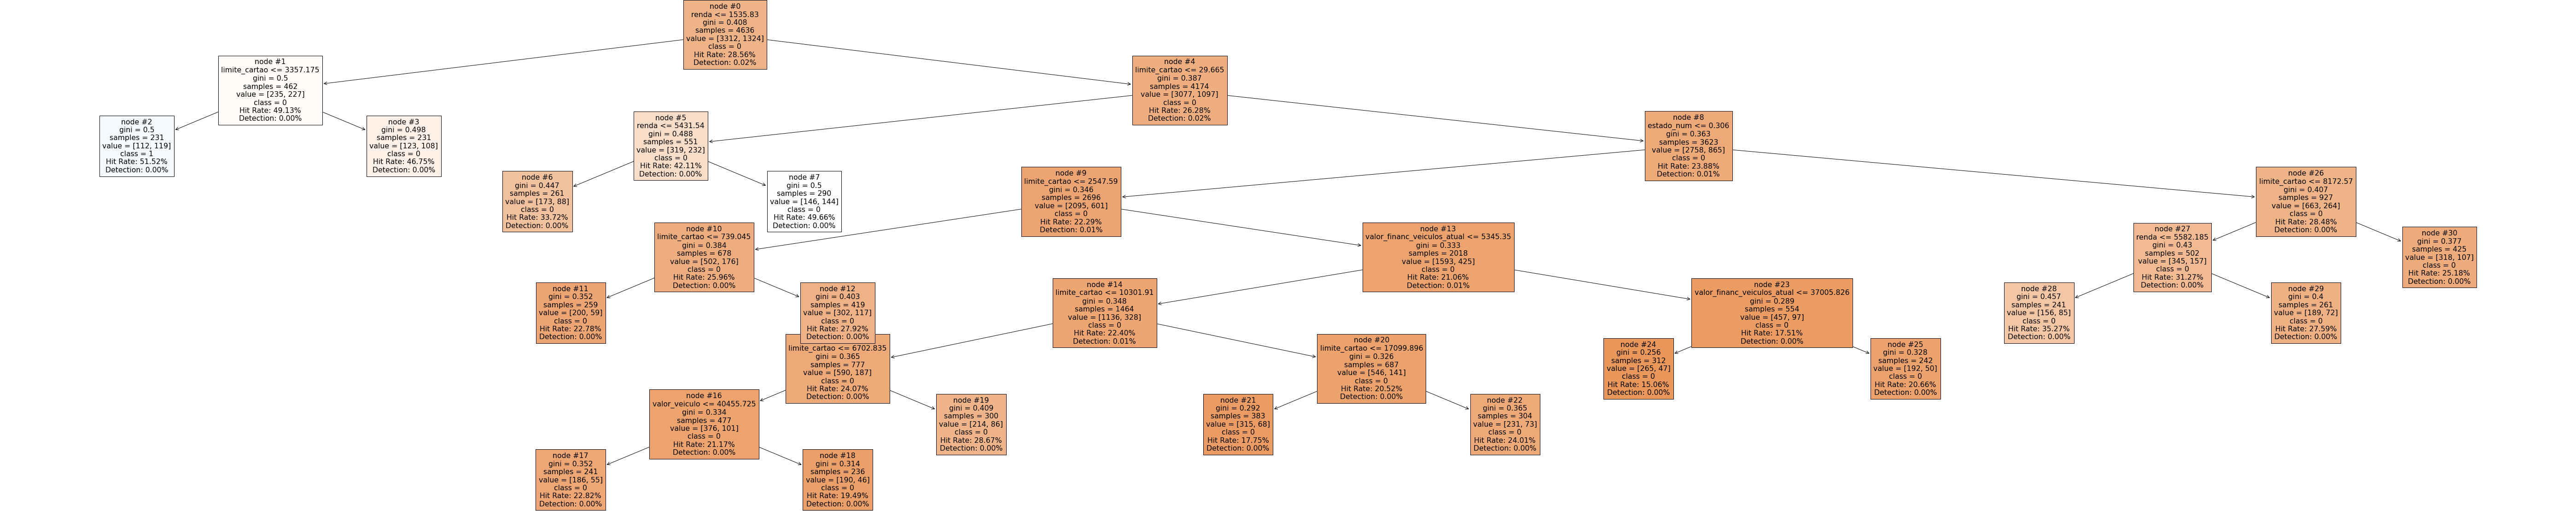

In [30]:
# Criação da árvore, com ajustes para o cálculo das métricas de Hit Rate e Detection

%matplotlib inline

target_valores = ['0', '1']

def calculate_class_ratios(tree, classes):
    class_ratios = []
    class_detection = []
    total_samples = tree.n_node_samples[0]*tree.value[0][0]
    for i in range(tree.node_count):
        counts = tree.value[i][0]
        total = counts.sum()
        ratios = counts / total
        node_samples = ratios*tree.n_node_samples[i]
        detection = np.divide(node_samples, total_samples)
        class_ratios.append({classes[j]: ratios[j] for j in range(len(classes))})
        class_detection.append({classes[j]: detection[j] for j in range(len(classes))})

    return class_ratios, class_detection

class_ratios, class_detection = calculate_class_ratios(models['Decision Tree'].tree_, target_valores)
plt.figure(figsize=(100, 20))
plot_tree(models['Decision Tree'], class_names=target_valores, filled=True, node_ids=True, feature_names=X_train.columns)

ax = plt.gca()
j = 0
for i, txt in enumerate(ax.texts):
    ratios = class_ratios[i - j]
    detection = class_detection[i - j]
    label = txt.get_text()+"\n"+f"Hit Rate: {ratios['1']:.2%}"+"\n"+f"Detection: {detection['1']:.2%}"
    txt.set_text(label)

In [31]:
# Extração das informações dos nós finais das árvores aplicadas às base de treino e teste

nodes_info = []

def get_node_rules(tree, feature_names, node_id=0, current_rule=""):
    left_child = tree.children_left[node_id]
    right_child = tree.children_right[node_id]
    
    # Verifica se é um nó final
    if left_child == -1 and right_child == -1:  # -1 indica que o nó é uma folha (nó final)
        rule = current_rule.strip("& ")
        total_cases = tree.n_node_samples[node_id]
        percentage_cases = total_cases / float(tree.n_node_samples[0])
        percentage_maus = tree.value[node_id][0][1] / total_cases
        
        nodes_info.append({
            "node": node_id,
            "rule": rule,
            "total_percentage": percentage_cases,
            "bad_rate": percentage_maus
        })
    else:
        # Se não for um nó final, continua construindo a regra
        feature = feature_names[tree.feature[node_id]]
        threshold = tree.threshold[node_id]
        
        get_node_rules(tree, feature_names, left_child, f"{current_rule}{feature} <= {threshold:.2f} & ")
        get_node_rules(tree, feature_names, right_child, f"{current_rule}{feature} > {threshold:.2f} & ")

get_node_rules(models['Decision Tree'].tree_, X_train.columns)

df_nodes = pd.DataFrame(nodes_info)

def simplify_rule(rule):
    conditions = rule.split(" & ")
    simplified_conditions = {}
    
    for cond in conditions:
        match = re.match(r"([a-zA-Z_]+) (<=|>=|<|>) ([0-9\.]+)", cond)
        if match:
            var, operator, value = match.groups()
            value = float(value)
            
            if var not in simplified_conditions:
                simplified_conditions[var] = {'<=': float('inf'), '>=': float('-inf')}
            
            if operator == '<=' and value < simplified_conditions[var]['<=']:
                simplified_conditions[var]['<='] = value
            elif operator == '>=' and value > simplified_conditions[var]['>=']:
                simplified_conditions[var]['>='] = value
            elif operator == '<' and value <= simplified_conditions[var]['<=']:
                simplified_conditions[var]['<='] = value
            elif operator == '>' and value >= simplified_conditions[var]['>=']:
                simplified_conditions[var]['>='] = value
    
    new_conditions = []
    for var, limits in simplified_conditions.items():
        if limits['>='] > float('-inf'):
            new_conditions.append(f"{var} > {limits['>=']}")
        if limits['<='] < float('inf'):
            new_conditions.append(f"{var} <= {limits['<=']}")
    
    return " & ".join(new_conditions)

df_nodes['simplified_rule'] = df_nodes['rule'].apply(simplify_rule)
df_nodes = df_nodes[['node', 'simplified_rule', 'total_percentage', 'bad_rate']]
node_indicator_test = models['Decision Tree'].apply(X_test)

df_test_with_nodes = X_test.copy()
df_test_with_nodes['node'] = node_indicator_test
df_test_with_nodes['target'] = y_test 

df_nodes_test = df_test_with_nodes.groupby('node').agg(
    num_cases=('target', 'size'),
    num_bads=('target', 'sum')
).reset_index()

df_nodes_test['total_percentage'] = df_nodes_test['num_cases'] / df_test_with_nodes.shape[0]
df_nodes_test['bad_rate'] = df_nodes_test['num_bads'] / df_nodes_test['num_cases']

df_nodes_test = df_nodes_test.merge(df_nodes[['node', 'simplified_rule']], on='node', how='left')

df_nodes_test = df_nodes_test[['node', 'simplified_rule', 'total_percentage', 'bad_rate']]

In [32]:
# Anotações sobre a árvore de decisão final:

# Nossos piores grupos são de clientes ou com baixa renda ou nula ("renda <= 1535.83 & limite_cartao <= 3357.18" e "renda <= 1535.83 & limite_cartao > 3357.18") 
# ou de clientes com limite do cartão zerado ou nulo ("renda > 5431.54 & limite_cartao <= 29.67" e 
# "renda > 1535.83 & renda <= 5431.54 & limite_cartao <= 29.67")

# Os outros casos caem em situações mais complexas e diversas, mas é de se provocar se os critérios acima não deveriam estar, de alguma forma, 
# incoporados na política dado o resultado de inadimplência.

# Como estamos falando de um corte da renda muito próximo ao salário mínimo, no frigir dos ovos podemos estar lidando com clientes autônomos, e que 
# talvez haja formas de contornar a situação do "negue qualquer pessoa com renda abaixo de X" com mais informações disponíveis.

# É importante notar como alguns nós da árvore têm mudanças bruscas de inadimplência na base de teste (nós 3, 6 e 19), e que isso pode significar um 
# alto grau de instabilidade do público. Como o modelo em si já está com uma performance no limite do aceitável, podemos seguir desta forma num primeiro 
# momento, monitorando o desempenho do modelo, e em paralelo buscarmos novas fontes de dados que sejam menos voláteis.

In [36]:
df_nodes

,node,simplified_rule,total_percentage,bad_rate
0,2,renda <= 1535.83 & limite_cartao <= 3357.18,0.049827,0.515152
1,3,renda <= 1535.83 & limite_cartao > 3357.18,0.049827,0.467532
2,6,renda > 1535.83 & renda <= 5431.54 & limite_cartao <= 29.67,0.056299,0.337165
3,7,renda > 5431.54 & limite_cartao <= 29.67,0.062554,0.496552
4,11,renda > 1535.83 & limite_cartao > 29.67 & limite_cartao <= 739.04 & estado_num <= 0.31,0.055867,0.227799
5,12,renda > 1535.83 & limite_cartao > 739.04 & limite_cartao <= 2547.59 & estado_num <= 0.31,0.090380,0.279236
6,17,renda > 1535.83 & limite_cartao > 2547.59 & limite_cartao <= 6702.83 & estado_num <= 0.31 & valor_financ_veiculos_atual <= 5345.35 & valor_veiculo <= 40455.72,0.051984,0.228216
7,18,renda > 1535.83 & limite_cartao > 2547.59 & limite_cartao <= 6702.83 & estado_num <= 0.31 & valor_financ_veiculos_atual <= 5345.35 & valor_veiculo > 40455.72,0.050906,0.194915
8,19,renda > 1535.83 & limite_cartao > 6702.83 & limite_cartao <= 10301.91 & estado_num <= 0.31 & valor_financ_veiculos_atual <= 5345.35,0.064711,0.286667
9,21,renda > 1535.83 & limite_cartao > 10301.91 & limite_cartao <= 17099.9 & estado_num <= 0.31 & valor_financ_veiculos_atual <= 5345.35,0.082614,0.177546


In [33]:
df_results = df_nodes.sort_values('bad_rate', ascending=False).copy()
df_results.rename(columns={'total_percentage': 'total_percentage_train', 'bad_rate': 'bad_rate_train'}, inplace=True)
df_results = df_results.merge(df_nodes_test[['node', 'total_percentage', 'bad_rate']], on='node', how='left')
df_results.rename(columns={'total_percentage': 'total_percentage_test', 'bad_rate': 'bad_rate_test'}, inplace=True)

df_results

,node,simplified_rule,total_percentage_train,bad_rate_train,total_percentage_test,bad_rate_test
0,2,renda <= 1535.83 & limite_cartao <= 3357.18,0.049827,0.515152,0.048646,0.504348
1,7,renda > 5431.54 & limite_cartao <= 29.67,0.062554,0.496552,0.066413,0.471338
2,3,renda <= 1535.83 & limite_cartao > 3357.18,0.049827,0.467532,0.042724,0.346535
3,28,renda > 1535.83 & renda <= 5582.19 & limite_cartao > 29.67 & limite_cartao <= 8172.57 & estado_num > 0.31,0.051984,0.352697,0.049492,0.324786
4,6,renda > 1535.83 & renda <= 5431.54 & limite_cartao <= 29.67,0.056299,0.337165,0.060914,0.479167
5,19,renda > 1535.83 & limite_cartao > 6702.83 & limite_cartao <= 10301.91 & estado_num <= 0.31 & valor_financ_veiculos_atual <= 5345.35,0.064711,0.286667,0.056261,0.157895
6,12,renda > 1535.83 & limite_cartao > 739.04 & limite_cartao <= 2547.59 & estado_num <= 0.31,0.090380,0.279236,0.093909,0.261261
7,29,renda > 5582.19 & limite_cartao > 29.67 & limite_cartao <= 8172.57 & estado_num > 0.31,0.056299,0.275862,0.057530,0.250000
8,30,renda > 1535.83 & limite_cartao > 8172.57 & estado_num > 0.31,0.091674,0.251765,0.103215,0.245902
9,22,renda > 1535.83 & limite_cartao > 17099.9 & estado_num <= 0.31 & valor_financ_veiculos_atual <= 5345.35,0.065574,0.240132,0.065144,0.240260


In [ ]:
# Anotações sobre o agrupamento dos nós das árvores:

# O agrupamento "Médio" ficou gigantesco? Sim, ficou. Com isso dito, de fato não há diferença relevante nos nós que o compõe. Além disso, estamos 
# tentando lidar da melhor forma possível com as claras mudanças em alguns dos nós (3, 6 e 19) como já reportado anteriormente.

In [54]:
bins = [0, 0.2, 0.3, 0.36, 1.0]
labels = ['Baixo', 'Médio', 'Alto', 'Altíssimo']

df_results['grouped_node'] = pd.cut(df_results['bad_rate_train'], bins=bins, labels=labels)

df_results_grouped = df_results.groupby('grouped_node', observed=False).agg({
    'total_percentage_train': 'sum',
    'bad_rate_train': lambda x: (x * df_results.loc[x.index, 'total_percentage_train']).sum() / df_results.loc[x.index, 'total_percentage_train'].sum(),
    'total_percentage_test': 'sum',
    'bad_rate_test': lambda x: (x * df_results.loc[x.index, 'total_percentage_test']).sum() / df_results.loc[x.index, 'total_percentage_test'].sum(),
    }).reset_index().sort_values('bad_rate_train', ascending=False)

df_results_grouped

,grouped_node,total_percentage_train,bad_rate_train,total_percentage_test,bad_rate_test
3,Altíssimo,0.162209,0.493351,0.157783,0.447721
2,Alto,0.108283,0.344622,0.110406,0.409962
1,Médio,0.528689,0.252550,0.539763,0.237461
0,Baixo,0.200820,0.172932,0.192047,0.218062


### Score cruzado - score interno + score de mercado

In [50]:
df_train['score'] = models['Decision Tree'].predict_proba(df_train[X_train.columns])[:, 1]
bins = [0, 0.2, 0.3, 0.36, 1.0]
labels = ['Baixo', 'Médio', 'Alto', 'Altíssimo']

df_train['score_binned'] = pd.cut(df_train['score'], bins=bins, labels=labels)

df_train['score_mercado_binned'] = pd.qcut(df_train['score_mercado'], 4)
score_cruzado = pd.pivot_table(df_train, 
                                index='score_binned', 
                                columns='score_mercado_binned', 
                                values='target_m3over30', 
                                aggfunc='mean', 
                                observed=False,
                                margins=True, 
                                margins_name='Total')

score_cruzado

score_mercado_binned,"(-1.001, 641.015]","(641.015, 775.0]","(775.0, 890.473]","(890.473, 1000.0]",Total
score_binned,,,,,
Baixo,0.211268,0.191667,0.158537,0.133621,0.172932
Médio,0.282288,0.233071,0.239812,0.259434,0.252550
Alto,0.414474,0.288000,0.322581,0.333333,0.344622
Altíssimo,0.500000,0.491124,0.482558,0.496855,0.493351
Total,0.333909,0.267750,0.265448,0.275237,0.285591
